In [1]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# For VADER sentiment analysis
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon (only need to do this once)
try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ Libraries imported successfully!")
print("✓ VADER sentiment analyzer initialized!")

✓ Libraries imported successfully!
✓ VADER sentiment analyzer initialized!


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\manor\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Step 2: Load your data
df = pd.read_csv(r'C:\Users\manor\Downloads\data\playlist_transcripts_complete.csv')

print(f"Dataset loaded: {len(df)} transcripts")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst row preview:")
print(df.head(1))

Dataset loaded: 51 transcripts

Columns: ['video_id', 'transcript_whisper', 'transcript_status', 'transcript_length', 'title', 'duration', 'order_in_playlist', 'playlist_url', 'run_ts_utc']

First row preview:
      video_id  \
0  -GhhcZUYmMk   

                                                                                    transcript_whisper  \
0  So I started using drugs when I was 12 years old. Really I just wanted to fit in with everyone, ...   

  transcript_status  transcript_length                       title  duration  \
0  loaded_from_file              15815  Recovery - Honesty's Story    1181.0   

   order_in_playlist  \
0                  5   

                                                                               playlist_url  \
0  https://youtube.com/playlist?list=PLdCPA32W_p39Z8hi7xSIX3Fkqmhd7mRzj&si=1NuXOm3x_FauXwSH   

                         run_ts_utc  
0  2025-10-24T20:37:36.824506+00:00  


In [3]:
# Step 3: Define recovery stages with keywords
STAGES = {
    "exposure_first_use": {
        "keywords": [
            "first time", "first tried", "started using", "was prescribed",
            "after surgery", "injury", "doctor gave", "curious", "peer pressure",
            "experimented", "introduced to", "pills", "party"
        ],
        "weights": {"first time": 3, "was prescribed": 3, "after surgery": 2}
    },
    
    "escalation": {
        "keywords": [
            "using daily", "couldn't stop", "tolerance", "needed more",
            "spiraled", "lying", "stealing", "lost control", "hiding",
            "double life", "obsessed", "chasing", "every day", "all the time"
        ],
        "weights": {"couldn't stop": 3, "lost control": 3, "spiraled": 2}
    },
    
    "rock_bottom": {
        "keywords": [
            "rock bottom", "hit bottom", "overdose", "od'd", "nearly died",
            "hospitalized", "homeless", "lost everything", "lost custody",
            "arrested", "jail", "prison", "suicidal", "wanted to die",
            "lost job", "lost family", "nowhere to go"
        ],
        "weights": {"overdose": 5, "nearly died": 5, "rock bottom": 4, 
                   "lost everything": 4, "suicidal": 4}
    },
    
    "turning_point": {
        "keywords": [
            "wake up call", "woke up", "turning point", "realized",
            "had to change", "enough was enough", "asked for help",
            "intervention", "my kids", "my child", "my family",
            "moment of clarity", "scared straight", "second chance"
        ],
        "weights": {"turning point": 4, "wake up call": 4, "intervention": 3}
    },
    
    "treatment_entry": {
        "keywords": [
            "detox", "rehab", "treatment", "inpatient", "outpatient",
            "checked in", "admitted", "12 step", "aa", "na",
            "sponsor", "therapist", "counselor", "mat",
            "suboxone", "methadone", "vivitrol", "naltrexone"
        ],
        "weights": {"detox": 3, "rehab": 3, "treatment": 2}
    },
    
    "early_recovery": {
        "keywords": [
            "withdrawal", "detoxing", "cravings", "urges", "triggers",
            "daily meetings", "90 in 90", "white knuckling", "one day at a time",
            "struggling", "hard days", "learning", "new routine", "staying clean"
        ],
        "weights": {"withdrawal": 3, "cravings": 2, "one day at a time": 2}
    },
    
    "relapse": {
        "keywords": [
            "relapsed", "slipped", "used again", "went back out",
            "picked up", "fell off", "back to using", "started using again"
        ],
        "weights": {"relapsed": 4, "used again": 3}
    },
    
    "maintenance": {
        "keywords": [
            "sober now", "clean for", "years sober", "months clean",
            "grateful", "gratitude", "giving back", "sponsoring",
            "help others", "peace", "purpose", "rebuilt", "stable",
            "found myself", "new life", "thriving", "recovery"
        ],
        "weights": {"years sober": 4, "giving back": 3, "grateful": 2}
    }
}

# Stage order for visualization
STAGE_ORDER = [
    'exposure_first_use', 'escalation', 'rock_bottom', 'turning_point',
    'treatment_entry', 'early_recovery', 'relapse', 'maintenance'
]

STAGE_LABELS = {
    'exposure_first_use': 'First Use',
    'escalation': 'Escalation',
    'rock_bottom': 'Rock Bottom',
    'turning_point': 'Turning Point',
    'treatment_entry': 'Treatment',
    'early_recovery': 'Early Recovery',
    'relapse': 'Relapse',
    'maintenance': 'Maintenance'
}

print("✓ Stage definitions loaded!")
print(f"Total stages: {len(STAGES)}")

✓ Stage definitions loaded!
Total stages: 8


In [4]:
# Step 4: Define loss categories with severity
LOSS_CATEGORIES = {
    "family_relationships": {
        "keywords": [
            "lost my family", "lost custody", "kids taken", "divorce",
            "left me", "couldn't see my kids", "restraining order",
            "family disowned", "lost my wife", "lost my husband"
        ],
        "severity": 5
    },
    
    "employment": {
        "keywords": [
            "lost my job", "fired", "couldn't work", "career gone",
            "lost everything i worked for", "business failed"
        ],
        "severity": 3
    },
    
    "housing": {
        "keywords": [
            "homeless", "living on streets", "lost my home",
            "evicted", "living in car", "couch surfing", "shelter"
        ],
        "severity": 4
    },
    
    "legal": {
        "keywords": [
            "arrested", "jail", "prison", "felony", "probation",
            "parole", "court", "charges", "convicted"
        ],
        "severity": 4
    },
    
    "health": {
        "keywords": [
            "overdose", "od'd", "hospitalized", "nearly died",
            "sick", "hepatitis", "hiv", "infection", "seizure"
        ],
        "severity": 5
    },
    
    "financial": {
        "keywords": [
            "bankrupt", "debt", "lost savings", "stole money",
            "pawned", "sold everything"
        ],
        "severity": 3
    },
    
    "identity": {
        "keywords": [
            "lost myself", "didn't know who i was", "wasn't me",
            "person i became", "hated myself", "soul"
        ],
        "severity": 4
    }
}

# Trauma indicators
TRAUMA_INDICATORS = {
    "childhood_trauma": ["abuse", "abused as child", "molested", "trauma", "violent home"],
    "loss_grief": ["died", "death", "lost someone", "grief", "passed away"],
    "violence": ["domestic violence", "beaten", "assault", "raped"],
    "mental_health": ["depression", "anxiety", "ptsd", "bipolar", "mental illness"]
}

print("✓ Loss and trauma categories defined!")

✓ Loss and trauma categories defined!


In [5]:
# Step 5: Better helper functions using context windows


def normalize_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text.lower()
    t = re.sub(r"\s+", " ", t).strip()
    return t


def split_into_chunks(text, chunk_size=500):
    """
    Split text into overlapping chunks (context windows)
    chunk_size = approximate number of words per chunk
    """
    words = text.split()
    chunks = []
    
    step_size = chunk_size // 2  # 50% overlap to catch events at boundaries
    
    for i in range(0, len(words), step_size):
        chunk = ' '.join(words[i:i + chunk_size])
        if len(chunk.strip()) > 0:
            chunks.append({
                'text': chunk,
                'start_word': i,
                'end_word': min(i + chunk_size, len(words)),
                'chunk_id': len(chunks)
            })
    
    return chunks

def calculate_sentiment(text):
    """Calculate sentiment using VADER"""
    try:
        scores = sia.polarity_scores(str(text))
        return scores['compound']
    except:
        return 0.0

def detect_stage_in_chunk(chunk_text, stage_name):
    """
    Detect if a stage is present in a specific chunk
    Returns presence score (0-1) rather than raw counts
    """
    text_lower = normalize_text(chunk_text)
    stage_info = STAGES[stage_name]
    keywords = stage_info['keywords']
    weights = stage_info.get('weights', {})
    
    # Check which keywords are present (binary: present or not)
    keywords_found = []
    total_weight = 0
    
    for keyword in keywords:
        keyword_lower = keyword.lower()
        pattern = r'\b' + re.escape(keyword_lower) + r'\b'
        
        if re.search(pattern, text_lower):
            weight = weights.get(keyword, 1)
            keywords_found.append(keyword)
            total_weight += weight
    
    # Presence score: how strongly this chunk relates to this stage
    # Max possible weight for this stage
    max_weight = sum(weights.values()) if weights else len(keywords)
    presence_score = min(total_weight / max_weight, 1.0) if max_weight > 0 else 0
    
    return {
        'present': len(keywords_found) > 0,
        'presence_score': presence_score,
        'keywords_found': keywords_found,
        'total_weight': total_weight
    }

def detect_losses_in_chunk(chunk_text):
    """Detect losses in a chunk (returns unique loss types only)"""
    text_lower = normalize_text(chunk_text)
    losses_found = set()  # Use set to avoid duplicates within chunk
    
    for loss_type, info in LOSS_CATEGORIES.items():
        for keyword in info['keywords']:
            if keyword.lower() in text_lower:
                losses_found.add(loss_type)
                break  # Only need one keyword match per loss type
    
    return list(losses_found)

def detect_trauma_in_chunk(chunk_text):
    """Detect trauma indicators in a chunk"""
    text_lower = normalize_text(chunk_text)
    traumas_found = set()
    
    for trauma_type, keywords in TRAUMA_INDICATORS.items():
        for keyword in keywords:
            if keyword.lower() in text_lower:
                traumas_found.add(trauma_type)
                break
    
    return list(traumas_found)

def analyze_chunks(chunks):
    """
    Analyze all chunks to build a journey map
    Returns chunk-level analysis with stages, sentiment, losses
    """
    chunk_analysis = []
    
    for chunk in chunks:
        chunk_text = chunk['text']
        
        # Detect stages in this chunk
        stage_scores = {}
        for stage in STAGE_ORDER:
            result = detect_stage_in_chunk(chunk_text, stage)
            stage_scores[stage] = result
        
        # Find dominant stage (highest presence score)
        dominant_stage = max(stage_scores.items(), 
                           key=lambda x: x[1]['presence_score'])
        
        # Calculate sentiment for this chunk
        sentiment = calculate_sentiment(chunk_text)
        
        # Detect losses and trauma
        losses = detect_losses_in_chunk(chunk_text)
        traumas = detect_trauma_in_chunk(chunk_text)
        
        chunk_analysis.append({
            'chunk_id': chunk['chunk_id'],
            'start_word': chunk['start_word'],
            'end_word': chunk['end_word'],
            'stage_scores': stage_scores,
            'dominant_stage': dominant_stage[0] if dominant_stage[1]['presence_score'] > 0 else None,
            'dominant_stage_score': dominant_stage[1]['presence_score'],
            'sentiment': sentiment,
            'losses': losses,
            'traumas': traumas
        })
    
    return chunk_analysis

def aggregate_from_chunks(chunk_analysis, word_count):
    """
    Aggregate chunk-level analysis into story-level metrics
    This avoids over-counting repeated mentions
    """
    
    # 1. Stage presence: if stage appears in ANY chunk with score > 0.3
    stage_presence = {}
    stage_emphasis = {}
    
    for stage in STAGE_ORDER:
        # Get all chunks where this stage appears
        chunks_with_stage = [
            c for c in chunk_analysis 
            if c['stage_scores'][stage]['presence_score'] > 0.3
        ]
        
        stage_presence[stage] = len(chunks_with_stage) > 0
        
        # Emphasis = number of chunks discussing this stage (capped at diminishing returns)
        # First chunk = full weight, subsequent chunks = less weight
        emphasis = 0
        for i, chunk in enumerate(chunks_with_stage):
            weight = 1.0 / (1 + i * 0.3)  # Diminishing returns
            emphasis += chunk['stage_scores'][stage]['presence_score'] * weight
        
        stage_emphasis[stage] = emphasis
    
    # 2. Unique losses across all chunks
    all_losses = set()
    for chunk in chunk_analysis:
        all_losses.update(chunk['losses'])
    
    # 3. Unique traumas
    all_traumas = set()
    for chunk in chunk_analysis:
        all_traumas.update(chunk['traumas'])
    
    # 4. Calculate severity with better methodology
    severity_score = 0
    
    # Stage emphasis contributes to severity
    for stage, emphasis in stage_emphasis.items():
        if stage in ['rock_bottom']:
            severity_score += emphasis * 5  # Rock bottom weighted heavily
        elif stage in ['escalation', 'relapse']:
            severity_score += emphasis * 3
        else:
            severity_score += emphasis * 1
    
    # Each unique loss adds to severity
    for loss_type in all_losses:
        severity_score += LOSS_CATEGORIES[loss_type]['severity']
    
    # Normalize
    severity_normalized = (severity_score / word_count) * 1000 if word_count > 0 else 0
    
    # 5. Overall sentiment (average across chunks)
    avg_sentiment = np.mean([c['sentiment'] for c in chunk_analysis])
    
    # 6. Journey progression (which stages appear in order)
    journey_sequence = []
    for chunk in chunk_analysis:
        if chunk['dominant_stage'] and chunk['dominant_stage'] not in journey_sequence:
            journey_sequence.append(chunk['dominant_stage'])
    
    return {
        'stage_presence': stage_presence,
        'stage_emphasis': stage_emphasis,
        'unique_losses': list(all_losses),
        'unique_traumas': list(all_traumas),
        'severity_score': severity_score,
        'severity_normalized': severity_normalized,
        'overall_sentiment': avg_sentiment,
        'journey_sequence': journey_sequence,
        'stages_mentioned': sum(stage_presence.values()),
        'chunk_analysis': chunk_analysis  # Keep for detailed analysis
    }

print("✓ Enhanced helper functions created!")

✓ Enhanced helper functions created!


In [6]:
# Step 6: Analyze all transcripts with context windows

def analyze_transcript_enhanced(row):
    """
    Enhanced analysis using context windows
    Avoids over-counting repeated mentions
    """
    video_id = row['video_id']
    text = row['transcript_whisper']
    title = row['title']
    
    # Basic stats
    word_count = len(text.split())
    
    # Split into chunks
    chunks = split_into_chunks(text, chunk_size=500)
    
    # Analyze each chunk
    chunk_analysis = analyze_chunks(chunks)
    
    # Aggregate to story level
    story_metrics = aggregate_from_chunks(chunk_analysis, word_count)
    
    # Determine narrative focus
    rock_bottom_emphasis = story_metrics['stage_emphasis'].get('rock_bottom', 0)
    escalation_emphasis = story_metrics['stage_emphasis'].get('escalation', 0)
    maintenance_emphasis = story_metrics['stage_emphasis'].get('maintenance', 0)
    treatment_emphasis = story_metrics['stage_emphasis'].get('treatment_entry', 0)
    
    trauma_emphasis = rock_bottom_emphasis + escalation_emphasis
    recovery_emphasis = maintenance_emphasis + treatment_emphasis
    
    if trauma_emphasis > recovery_emphasis * 1.5:
        narrative_focus = 'trauma'
    elif recovery_emphasis > trauma_emphasis * 1.5:
        narrative_focus = 'recovery'
    else:
        narrative_focus = 'balanced'
    
    return {
        'video_id': video_id,
        'title': title,
        'word_count': word_count,
        'num_chunks': len(chunks),
        'severity_score': story_metrics['severity_score'],
        'severity_normalized': story_metrics['severity_normalized'],
        'overall_sentiment': story_metrics['overall_sentiment'],
        'stages_mentioned': story_metrics['stages_mentioned'],
        'completeness': story_metrics['stages_mentioned'] / len(STAGES),
        'narrative_focus': narrative_focus,
        'stage_presence': story_metrics['stage_presence'],
        'stage_emphasis': story_metrics['stage_emphasis'],
        'journey_sequence': story_metrics['journey_sequence'],
        'unique_losses': story_metrics['unique_losses'],
        'unique_traumas': story_metrics['unique_traumas'],
        'chunk_analysis': chunk_analysis
    }

# Run analysis
print("Analyzing all transcripts with context windows...")
results = []
for idx, row in df.iterrows():
    if (idx + 1) % 10 == 0:
        print(f"  Processed {idx + 1}/{len(df)}...")
    results.append(analyze_transcript_enhanced(row))

print(f"✓ Enhanced analysis complete! {len(results)} transcripts analyzed")

Analyzing all transcripts with context windows...
  Processed 10/51...
  Processed 20/51...
  Processed 30/51...
  Processed 40/51...
  Processed 50/51...
✓ Enhanced analysis complete! 51 transcripts analyzed


In [7]:
journey_sequence = ['exposure_first_use', 'escalation', 'rock_bottom', 
                   'treatment_entry', 'maintenance']
# Shows actual progression through their story

In [8]:
# Step 7: Create summary dataframes (fixed)

summary_rows = []
for r in results:
    row_data = {
        'video_id': r['video_id'],
        'title': r['title'],
        'word_count': r['word_count'],
        'severity_score': r['severity_score'],
        'severity_normalized': r['severity_normalized'],
        'overall_sentiment': r['overall_sentiment'],
        'stages_mentioned': r['stages_mentioned'],
        'completeness': r['completeness'],
        'narrative_focus': r['narrative_focus']
    }
    # add stage presence + normalized emphasis
    for stage in STAGE_ORDER:
        present = r['stage_presence'].get(stage, False)
        emph = r['stage_emphasis'].get(stage, 0.0)
        row_data[f'has_{stage}'] = bool(present)
        row_data[f'emphasis_{stage}'] = emph
        row_data[f'emphasis_norm_{stage}'] = (emph / r['word_count'] * 1000) if r['word_count'] > 0 else 0.0
    summary_rows.append(row_data)

summary_df = pd.DataFrame(summary_rows)

# Losses dataframe (unique types per person)
loss_rows = []
for r in results:
    for loss_type in r['unique_losses']:
        loss_rows.append({
            'video_id': r['video_id'],
            'title': r['title'],
            'loss_type': loss_type,
            'severity': LOSS_CATEGORIES[loss_type]['severity']
        })
loss_df = pd.DataFrame(loss_rows)

# Traumas dataframe (unique types per person)
trauma_rows = []
for r in results:
    for trauma_type in r['unique_traumas']:
        trauma_rows.append({
            'video_id': r['video_id'],
            'title': r['title'],
            'trauma_type': trauma_type
        })
trauma_df = pd.DataFrame(trauma_rows)

print("✓ DataFrames created!")
print(f"  - summary_df: {len(summary_df)} rows")
print(f"  - loss_df: {len(loss_df)} rows")
print(f"  - trauma_df: {len(trauma_df)} rows")


✓ DataFrames created!
  - summary_df: 51 rows
  - loss_df: 120 rows
  - trauma_df: 81 rows


In [9]:
# Step 8: Get top 10 worst journeys
top_10 = summary_df.nlargest(10, 'severity_normalized')

print("="*80)
print("TOP 10 WORST JOURNEYS (by Normalized Severity)")
print("="*80)

for i, (idx, row) in enumerate(top_10.iterrows(), 1):
    print(f"\n#{i}: {row['title']}")
    print(f"   Video ID: {row['video_id']}")
    print(f"   Normalized Severity: {row['severity_normalized']:.2f}")
    print(f"   Overall Sentiment: {row['overall_sentiment']:.3f}")
    print(f"   Stages: {row['stages_mentioned']}/8")
    print(f"   Focus: {row['narrative_focus']}")
    
    # Show losses
    person_losses = loss_df[loss_df['video_id'] == row['video_id']]
    if len(person_losses) > 0:
        losses_list = person_losses['loss_type'].unique()
        print(f"   Losses: {', '.join(losses_list)}")

TOP 10 WORST JOURNEYS (by Normalized Severity)

#1: Mike's Story - The Fires of Recovery
   Video ID: 4K1Sz0vcJEI
   Normalized Severity: 12.59
   Overall Sentiment: 0.889
   Stages: 2/8
   Focus: recovery
   Losses: legal, housing, health

#2: Nathan's Story - In Service to Others
   Video ID: 6cvmIM0kOh8
   Normalized Severity: 11.81
   Overall Sentiment: 0.969
   Stages: 5/8
   Focus: recovery
   Losses: legal, housing, health, family_relationships

#3: FENTANYL KILLS: Ricky Evans' Story - episode 198
   Video ID: vMAXWyrC8nM
   Normalized Severity: 10.32
   Overall Sentiment: 0.517
   Stages: 0/8
   Focus: balanced
   Losses: legal, family_relationships, health

#4: FENTANYL POISONING: Survivor Chelsea Chanslor
   Video ID: ZMETz0qGAYw
   Normalized Severity: 9.67
   Overall Sentiment: 0.292
   Stages: 3/8
   Focus: recovery
   Losses: legal, health, identity

#5: FENTANYL KILLS - Losing Five - episode 287
   Video ID: cSEjTH120Zw
   Normalized Severity: 9.61
   Overall Sentiment: 

In [10]:
# Step 9: Extract sentiment for each stage per person

def extract_stage_sentiments(text, video_id):
    """Extract sentiment around stage keywords using consistent casing for search & slice."""
    orig = str(text)
    low = orig.lower()
    stage_sentiments = []

    for stage in STAGE_ORDER:
        stage_info = STAGES[stage]
        keywords = stage_info['keywords']

        contexts = []
        for keyword in keywords:
            k = keyword.lower()
            pattern = r'\b' + re.escape(k) + r'\b'
            for m in re.finditer(pattern, low):
                pos = m.start()
                start = max(0, pos - 100)
                end = min(len(low), pos + 100)
                # slice on the same (lowercased) string we searched to avoid index drift
                ctx = low[start:end]
                contexts.append(ctx)

        if contexts:
            sentiments = [calculate_sentiment(ctx) for ctx in contexts]
            avg_sentiment = float(np.mean(sentiments))
            present = True
        else:
            avg_sentiment = 0.0
            present = False

        stage_sentiments.append({
            'video_id': video_id,
            'stage': stage,
            'stage_label': STAGE_LABELS[stage],
            'stage_index': STAGE_ORDER.index(stage),
            'sentiment': avg_sentiment,
            'present': present
        })

    return pd.DataFrame(stage_sentiments)


# Extract for top 10
print("Extracting stage sentiments for top 10...")
top_10_ids = top_10['video_id'].tolist()

all_stage_data = []
for video_id in top_10_ids:
    text = df[df['video_id'] == video_id]['transcript_whisper'].iloc[0]
    stage_df = extract_stage_sentiments(text, video_id)
    all_stage_data.append(stage_df)

combined_stages = pd.concat(all_stage_data, ignore_index=True)
print("✓ Stage sentiments extracted!")

Extracting stage sentiments for top 10...
✓ Stage sentiments extracted!


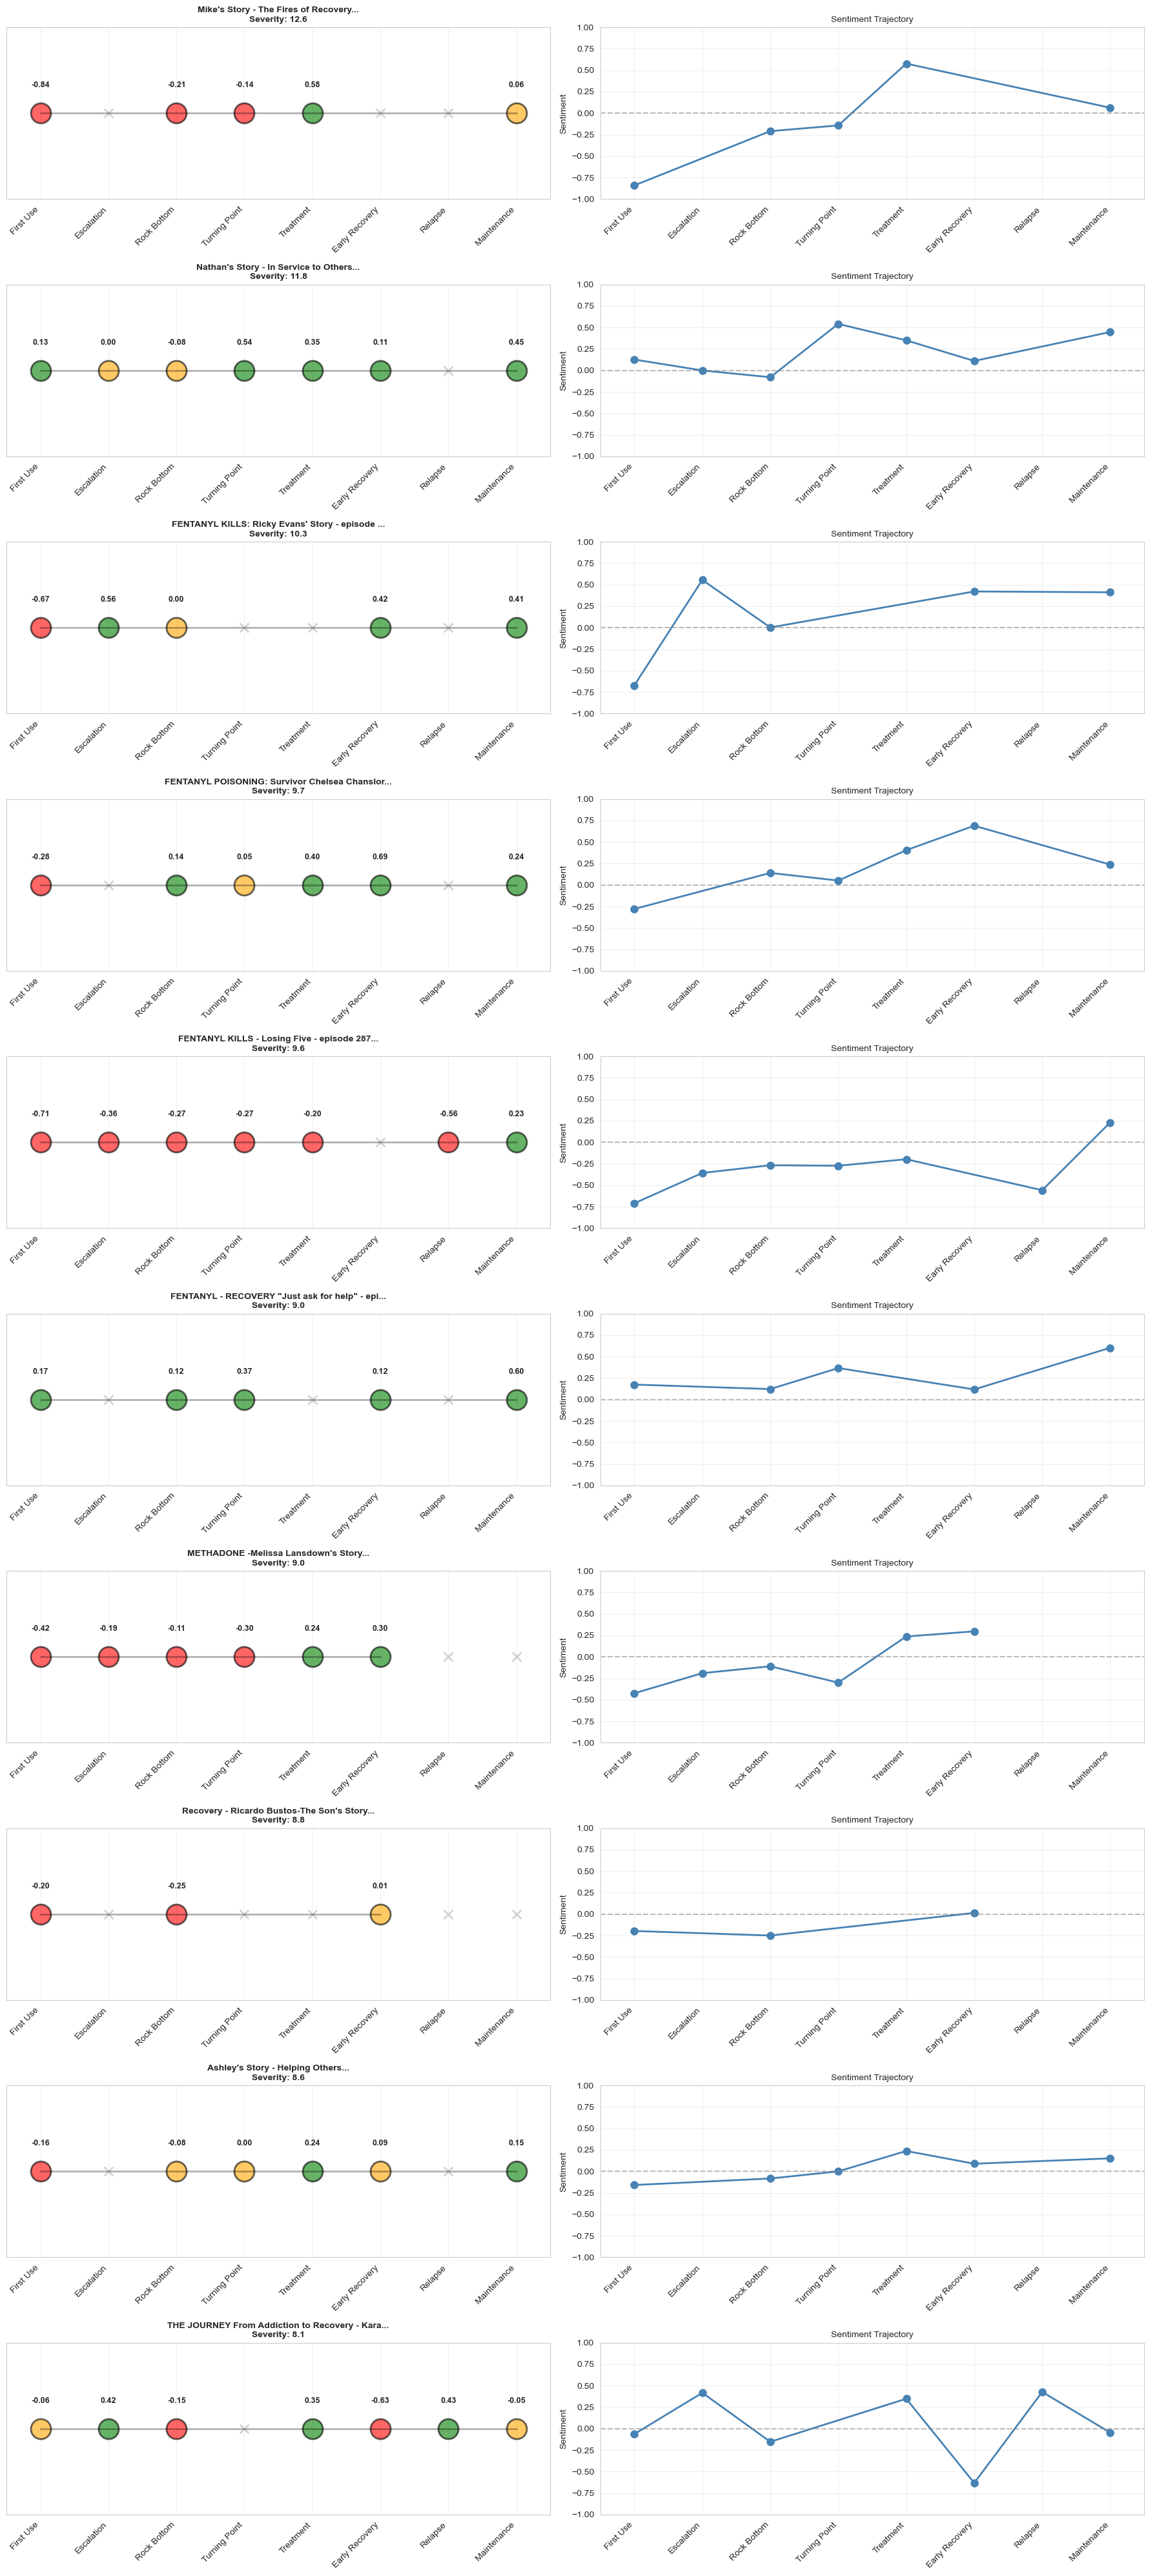

✓ Journey maps created!


In [11]:
# Step 10: Create journey maps for top 10

fig, axes = plt.subplots(10, 2, figsize=(18, 40))

for idx, video_id in enumerate(top_10_ids):
    # Get data
    person_df = combined_stages[combined_stages['video_id'] == video_id]
    person_summary = summary_df[summary_df['video_id'] == video_id].iloc[0]
    title = person_summary['title']
    severity = person_summary['severity_normalized']
    
    # Left plot: Journey timeline
    ax1 = axes[idx, 0]
    stages_present = person_df[person_df['present'] == True]
    
    for _, row in stages_present.iterrows():
        stage_idx = row['stage_index']
        sent = row['sentiment']
        
        # Color based on sentiment
        if sent > 0.1:
            color = 'green'
        elif sent < -0.1:
            color = 'red'
        else:
            color = 'orange'
        
        ax1.scatter(stage_idx, 0, s=500, c=color, alpha=0.6, edgecolors='black', linewidths=2)
        ax1.text(stage_idx, 0.15, f'{sent:.2f}', ha='center', fontsize=9, fontweight='bold')
    
    # Connect stages
    if len(stages_present) > 1:
        x_coords = stages_present['stage_index'].values
        ax1.plot(x_coords, [0]*len(x_coords), 'k-', alpha=0.3, linewidth=2)
    
    # Mark missing stages
    stages_missing = person_df[person_df['present'] == False]
    for _, row in stages_missing.iterrows():
        ax1.scatter(row['stage_index'], 0, s=100, c='lightgray', marker='x', linewidths=2)
    
    ax1.set_xlim(-0.5, 7.5)
    ax1.set_ylim(-0.5, 0.5)
    ax1.set_xticks(range(8))
    ax1.set_xticklabels([STAGE_LABELS[s] for s in STAGE_ORDER], rotation=45, ha='right')
    ax1.set_yticks([])
    ax1.set_title(f'{title[:45]}...\nSeverity: {severity:.1f}', fontsize=10, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Right plot: Sentiment trajectory
    ax2 = axes[idx, 1]
    x_coords = stages_present['stage_index'].values
    y_coords = stages_present['sentiment'].values
    
    if len(x_coords) > 0:
        ax2.plot(x_coords, y_coords, 'o-', linewidth=2, markersize=8, color='steelblue')
        ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    ax2.set_xlim(-0.5, 7.5)
    ax2.set_ylim(-1, 1)
    ax2.set_xticks(range(8))
    ax2.set_xticklabels([STAGE_LABELS[s] for s in STAGE_ORDER], rotation=45, ha='right')
    ax2.set_ylabel('Sentiment')
    ax2.set_title('Sentiment Trajectory', fontsize=10)
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('journey_maps_top10.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Journey maps created!")

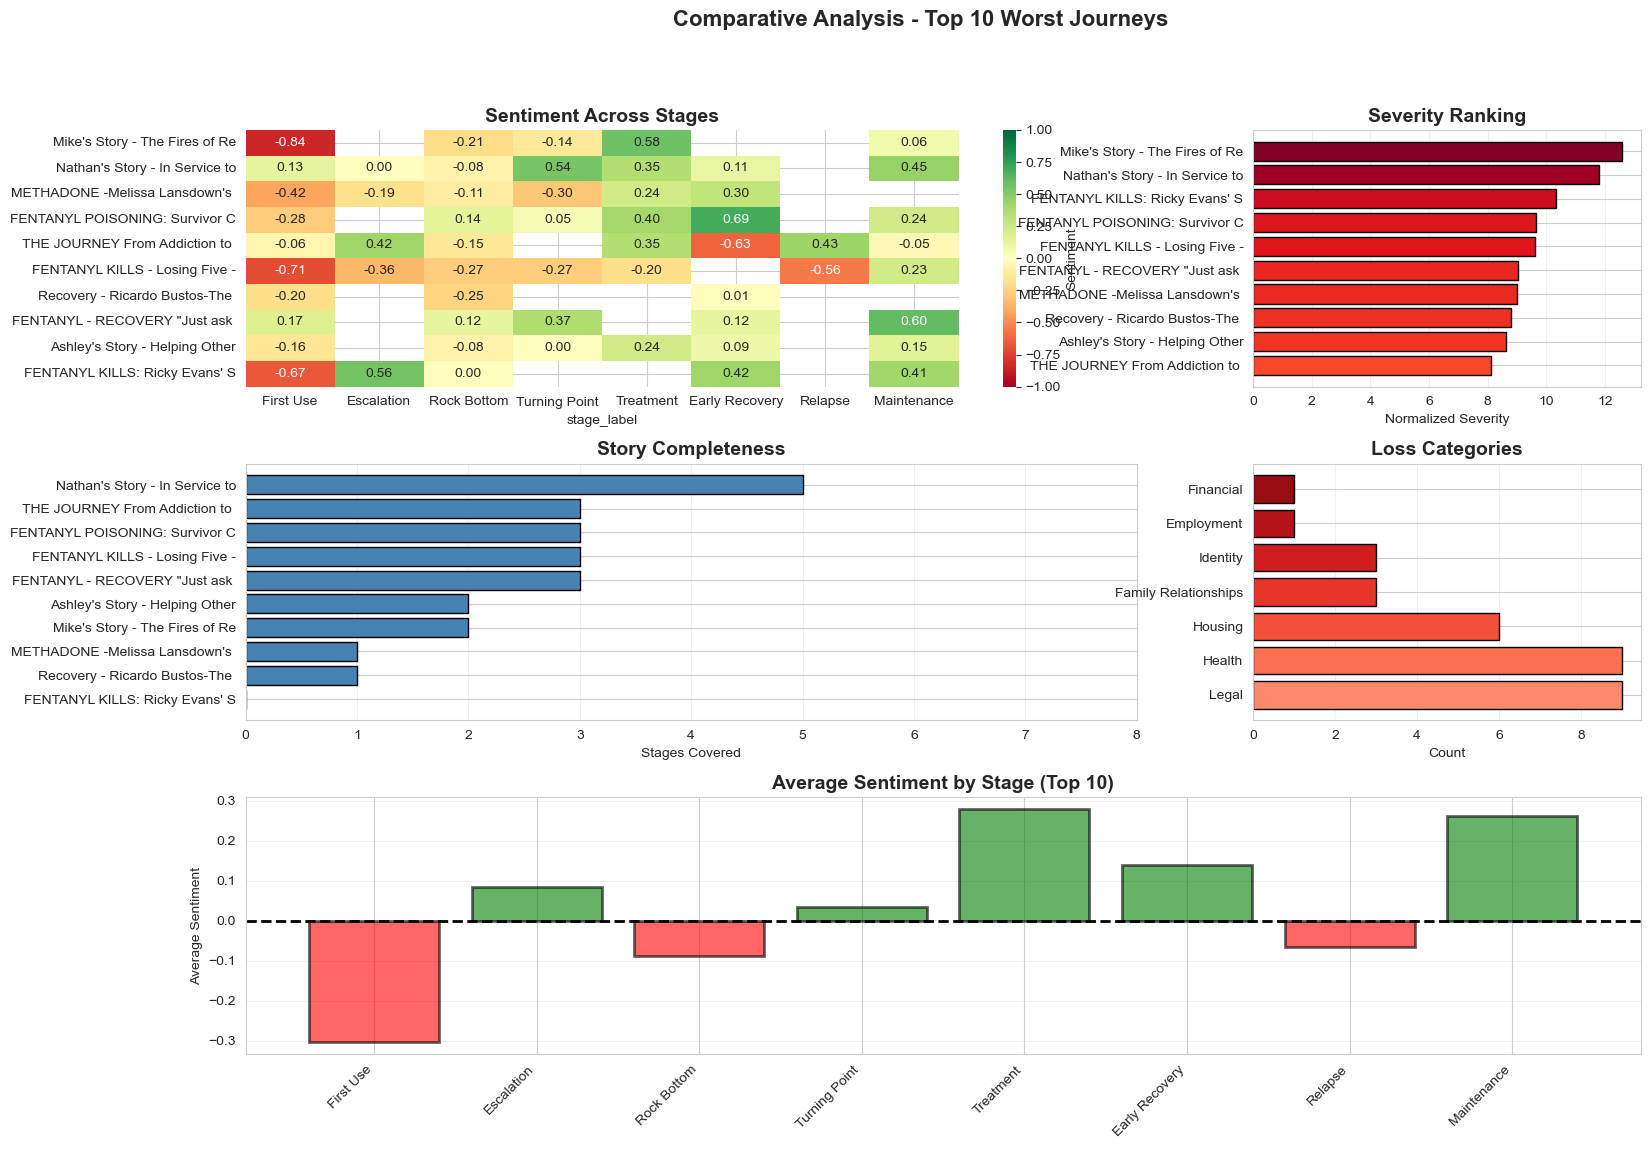

✓ Comparative analysis created!


In [12]:
# Step 11: Create comparative visualizations

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Sentiment Heatmap
ax1 = fig.add_subplot(gs[0, :2])

sentiment_pivot = combined_stages[combined_stages['present'] == True].pivot_table(
    index='video_id',
    columns='stage_label',
    values='sentiment',
    aggfunc='mean'
)

# Reorder columns
col_order = [STAGE_LABELS[s] for s in STAGE_ORDER if STAGE_LABELS[s] in sentiment_pivot.columns]
sentiment_pivot = sentiment_pivot[col_order]

# Add titles
title_map = dict(zip(top_10['video_id'], top_10['title'].str[:30]))
sentiment_pivot.index = [title_map.get(vid, vid) for vid in sentiment_pivot.index]

sns.heatmap(sentiment_pivot, cmap='RdYlGn', center=0, annot=True, fmt='.2f',
           cbar_kws={'label': 'Sentiment'}, ax=ax1, vmin=-1, vmax=1)
ax1.set_title('Sentiment Across Stages', fontsize=14, fontweight='bold')
ax1.set_ylabel('')

# 2. Severity Comparison
ax2 = fig.add_subplot(gs[0, 2])

severity_df = top_10[['title', 'severity_normalized']].copy()
severity_df['title'] = severity_df['title'].str[:30]
severity_df = severity_df.sort_values('severity_normalized')

colors = plt.cm.YlOrRd(severity_df['severity_normalized'] / severity_df['severity_normalized'].max())
ax2.barh(severity_df['title'], severity_df['severity_normalized'], color=colors, edgecolor='black')
ax2.set_xlabel('Normalized Severity')
ax2.set_title('Severity Ranking', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# 3. Stage Coverage
ax3 = fig.add_subplot(gs[1, :2])

coverage_df = top_10[['title', 'stages_mentioned']].copy()
coverage_df['title'] = coverage_df['title'].str[:30]
coverage_df = coverage_df.sort_values('stages_mentioned')

ax3.barh(coverage_df['title'], coverage_df['stages_mentioned'], color='steelblue', edgecolor='black')
ax3.set_xlabel('Stages Covered')
ax3.set_title('Story Completeness', fontsize=14, fontweight='bold')
ax3.set_xlim(0, 8)
ax3.grid(True, alpha=0.3, axis='x')

# 4. Loss Patterns
ax4 = fig.add_subplot(gs[1, 2])

top_10_losses = loss_df[loss_df['video_id'].isin(top_10_ids)]
loss_counts = top_10_losses['loss_type'].value_counts()

colors_loss = plt.cm.Reds(np.linspace(0.4, 0.9, len(loss_counts)))
ax4.barh(range(len(loss_counts)), loss_counts.values, color=colors_loss, edgecolor='black')
ax4.set_yticks(range(len(loss_counts)))
ax4.set_yticklabels([l.replace('_', ' ').title() for l in loss_counts.index])
ax4.set_xlabel('Count')
ax4.set_title('Loss Categories', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# 5. Average Sentiment by Stage
ax5 = fig.add_subplot(gs[2, :])

stages_present_all = combined_stages[combined_stages['present'] == True]
avg_sentiment_by_stage = stages_present_all.groupby('stage_label')['sentiment'].mean()
avg_sentiment_by_stage = avg_sentiment_by_stage.reindex([STAGE_LABELS[s] for s in STAGE_ORDER if STAGE_LABELS[s] in avg_sentiment_by_stage.index])

colors_sent = ['red' if x < 0 else 'green' for x in avg_sentiment_by_stage.values]
ax5.bar(range(len(avg_sentiment_by_stage)), avg_sentiment_by_stage.values, 
       color=colors_sent, alpha=0.6, edgecolor='black', linewidth=2)
ax5.axhline(y=0, color='black', linestyle='--', linewidth=2)
ax5.set_xticks(range(len(avg_sentiment_by_stage)))
ax5.set_xticklabels(avg_sentiment_by_stage.index, rotation=45, ha='right')
ax5.set_ylabel('Average Sentiment')
ax5.set_title('Average Sentiment by Stage (Top 10)', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

plt.suptitle('Comparative Analysis - Top 10 Worst Journeys', fontsize=16, fontweight='bold')
plt.savefig('comparative_analysis_top10.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Comparative analysis created!")

In [13]:
# Step 12: Print summary statistics

print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

print("\n1. OVERALL DATASET:")
print(f"   Total transcripts: {len(summary_df)}")
print(f"   Average severity (normalized): {summary_df['severity_normalized'].mean():.2f}")
print(f"   Average sentiment: {summary_df['overall_sentiment'].mean():.3f}")
print(f"   Average stages covered: {summary_df['stages_mentioned'].mean():.1f}/8")

print("\n2. TOP 10 WORST:")
print(f"   Average severity (normalized): {top_10['severity_normalized'].mean():.2f}")
print(f"   Average sentiment: {top_10['overall_sentiment'].mean():.3f}")
print(f"   Average stages covered: {top_10['stages_mentioned'].mean():.1f}/8")

print("\n3. MOST COMMON LOSSES IN TOP 10:")
top_10_losses = loss_df[loss_df['video_id'].isin(top_10_ids)]
loss_counts = top_10_losses['loss_type'].value_counts()
for loss_type, count in loss_counts.head(5).items():
    pct = (count / len(top_10)) * 100
    print(f"   {loss_type.replace('_', ' ').title()}: {count}/10 ({pct:.0f}%)")

print("\n4. STAGE COVERAGE IN TOP 10:")
for stage in STAGE_ORDER:
    count = top_10[f'has_{stage}'].sum()
    pct = (count / len(top_10)) * 100
    print(f"   {STAGE_LABELS[stage]}: {count}/10 ({pct:.0f}%)")

print("\n" + "="*80)


SUMMARY STATISTICS

1. OVERALL DATASET:
   Total transcripts: 51
   Average severity (normalized): 5.50
   Average sentiment: 0.455
   Average stages covered: 2.0/8

2. TOP 10 WORST:
   Average severity (normalized): 9.76
   Average sentiment: 0.481
   Average stages covered: 2.3/8

3. MOST COMMON LOSSES IN TOP 10:
   Legal: 9/10 (90%)
   Health: 9/10 (90%)
   Housing: 6/10 (60%)
   Family Relationships: 3/10 (30%)
   Identity: 3/10 (30%)

4. STAGE COVERAGE IN TOP 10:
   First Use: 6/10 (60%)
   Escalation: 1/10 (10%)
   Rock Bottom: 2/10 (20%)
   Turning Point: 2/10 (20%)
   Treatment: 6/10 (60%)
   Early Recovery: 2/10 (20%)
   Relapse: 2/10 (20%)
   Maintenance: 2/10 (20%)



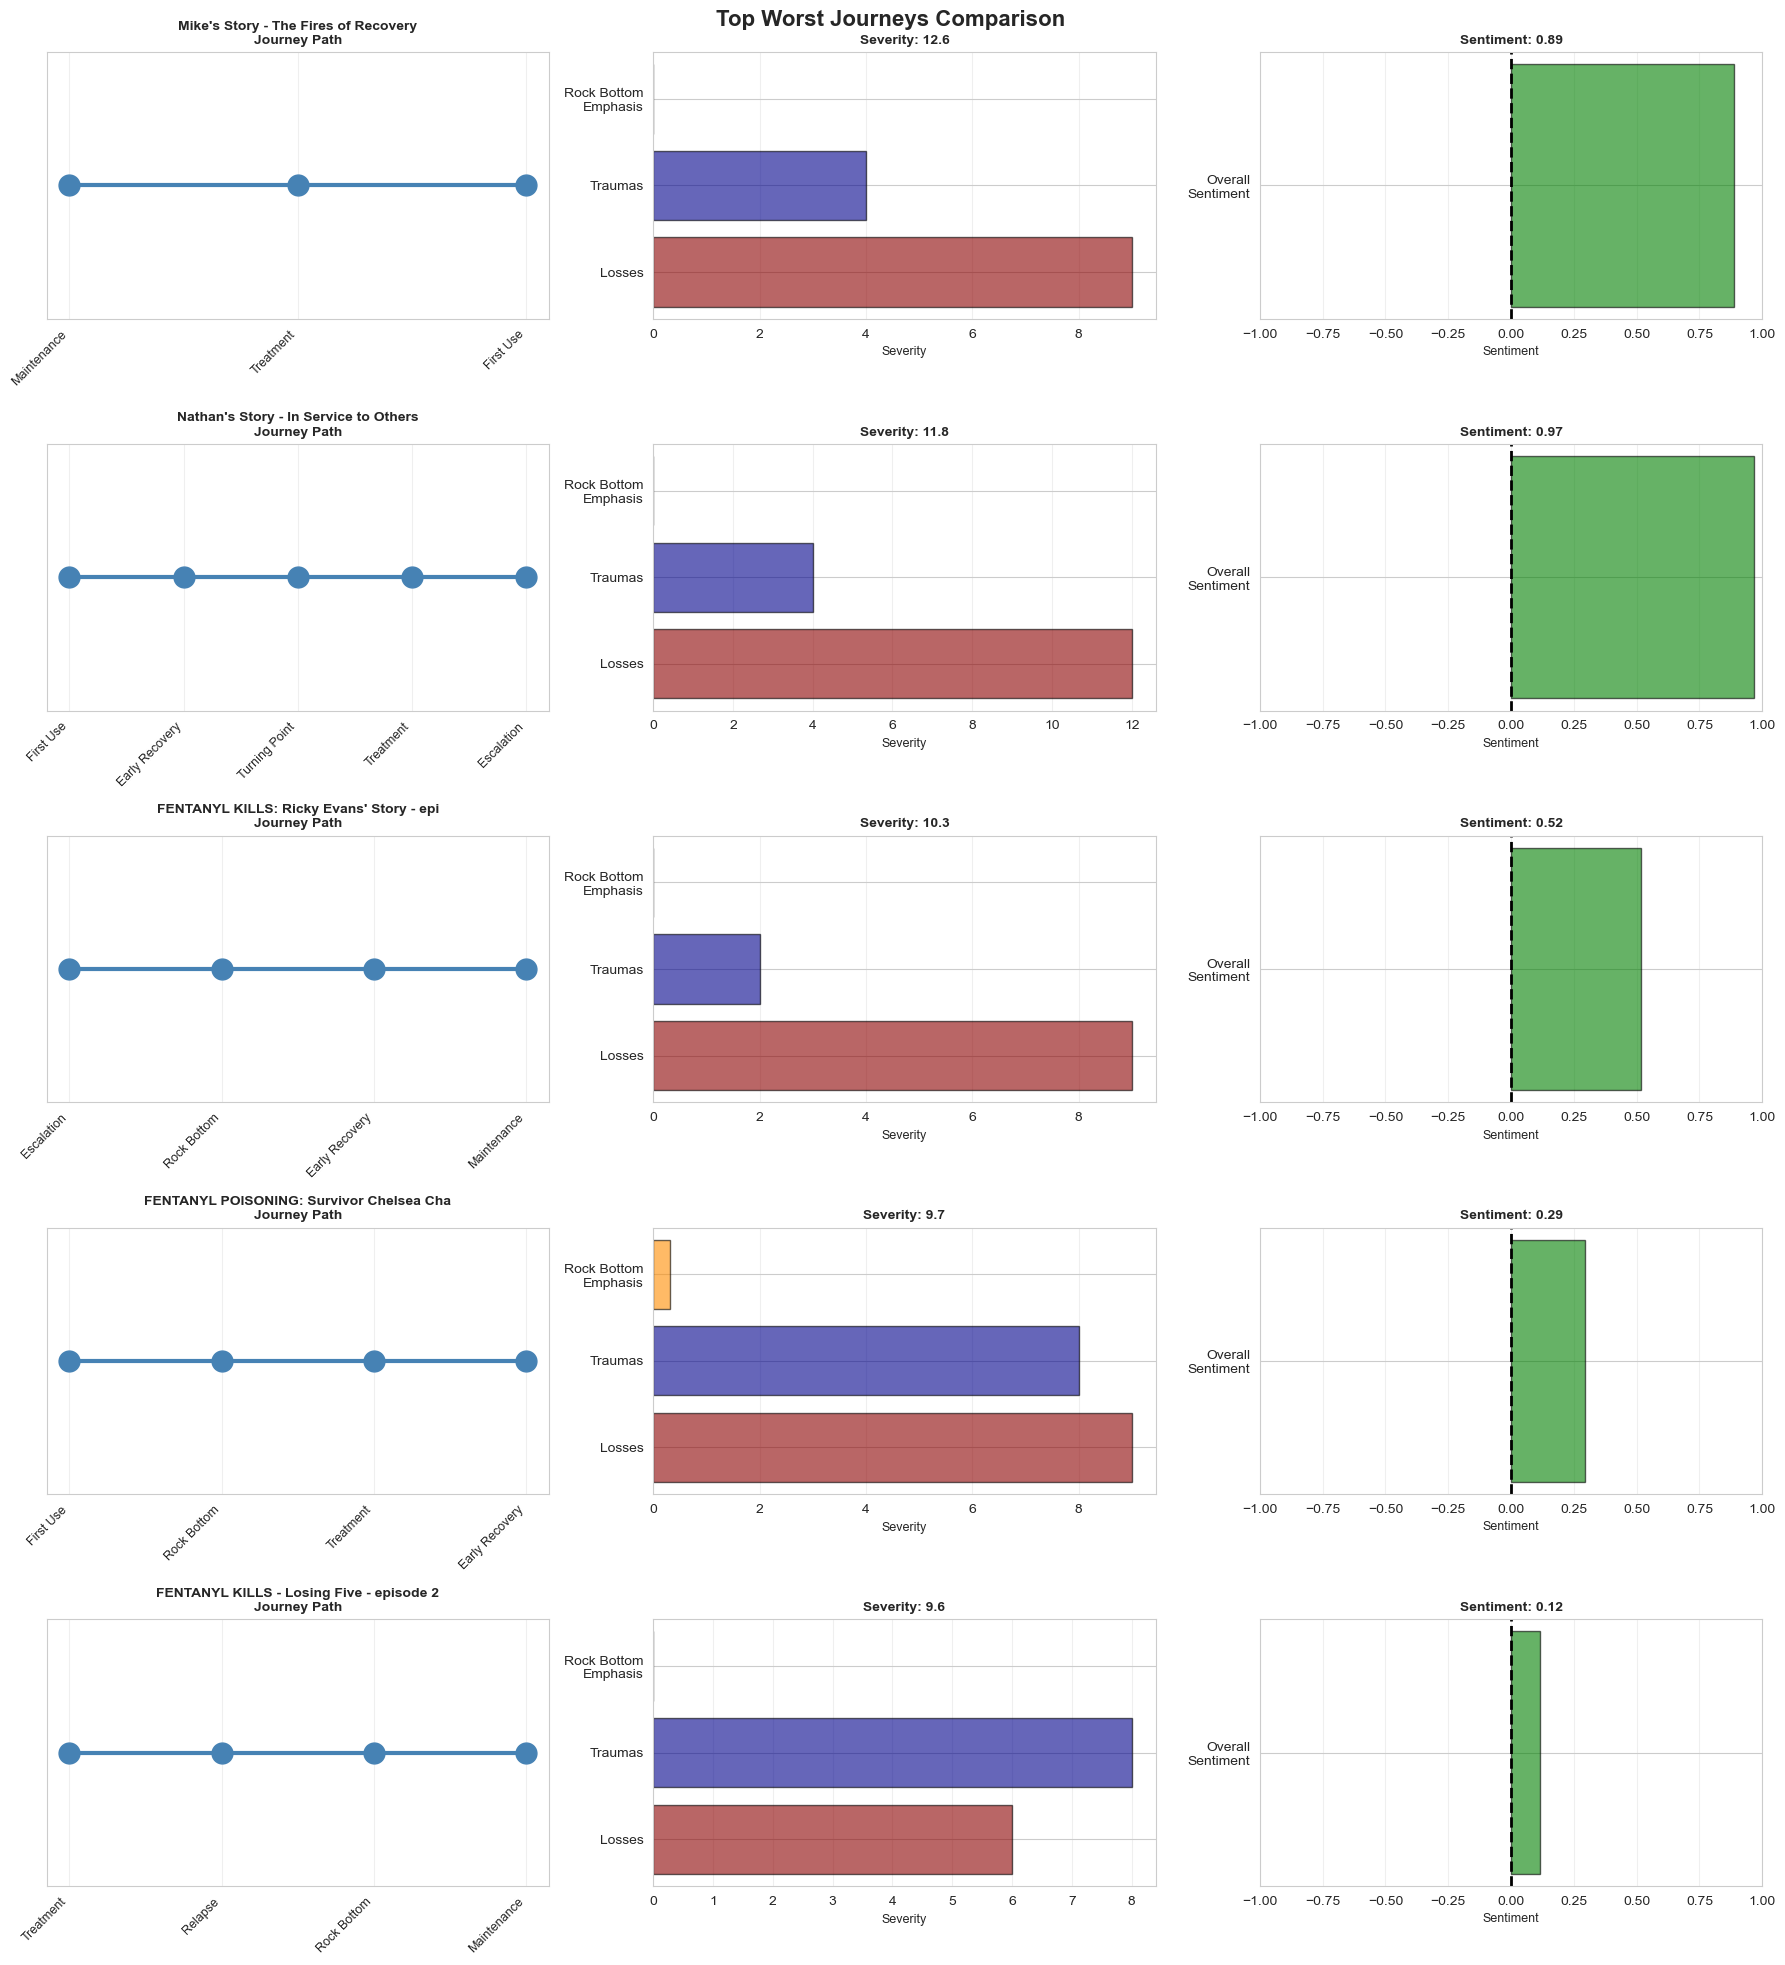

In [14]:
def create_comparison_dashboard(top_n_ids, results_list):
    """
    Compare multiple people side by side
    """
    fig, axes = plt.subplots(len(top_n_ids), 3, figsize=(18, 4*len(top_n_ids)))
    
    if len(top_n_ids) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, video_id in enumerate(top_n_ids):
        person = [r for r in results_list if r['video_id'] == video_id][0]
        title = person['title'][:40]
        
        # Column 1: Journey path
        ax1 = axes[idx, 0]
        journey = person['journey_sequence']
        
        if journey:
            stage_labels = [STAGE_LABELS[s] for s in journey]
            ax1.plot(range(len(journey)), [0]*len(journey), 'o-', 
                    linewidth=3, markersize=15, color='steelblue')
            ax1.set_xticks(range(len(journey)))
            ax1.set_xticklabels(stage_labels, rotation=45, ha='right', fontsize=9)
            ax1.set_yticks([])
            ax1.set_title(f'{title}\nJourney Path', fontsize=10, fontweight='bold')
            ax1.grid(True, alpha=0.3, axis='x')
        
        # Column 2: Severity breakdown
        ax2 = axes[idx, 1]
        
        losses_count = len(person['unique_losses'])
        trauma_count = len(person['unique_traumas'])
        rock_bottom = person['stage_emphasis'].get('rock_bottom', 0)
        
        categories = ['Losses', 'Traumas', 'Rock Bottom\nEmphasis']
        values = [losses_count * 3, trauma_count * 2, rock_bottom]
        
        colors = ['darkred', 'darkblue', 'darkorange']
        ax2.barh(categories, values, color=colors, alpha=0.6, edgecolor='black')
        ax2.set_xlabel('Severity', fontsize=9)
        ax2.set_title(f'Severity: {person["severity_normalized"]:.1f}', 
                     fontsize=10, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='x')
        
        # Column 3: Sentiment
        ax3 = axes[idx, 2]
        
        sentiment = person['overall_sentiment']
        color = 'green' if sentiment > 0.1 else 'red' if sentiment < -0.1 else 'orange'
        
        ax3.barh(['Overall\nSentiment'], [sentiment], color=color, alpha=0.6, edgecolor='black')
        ax3.set_xlim(-1, 1)
        ax3.axvline(x=0, color='black', linestyle='--', linewidth=2)
        ax3.set_xlabel('Sentiment', fontsize=9)
        ax3.set_title(f'Sentiment: {sentiment:.2f}', fontsize=10, fontweight='bold')
        ax3.grid(True, alpha=0.3, axis='x')
    
    plt.suptitle('Top Worst Journeys Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('comparison_dashboard.png', dpi=150, bbox_inches='tight')
    plt.show()

# Compare top 5
top_5_ids = top_10['video_id'].head(5).tolist()
create_comparison_dashboard(top_5_ids, results)

# Causal Pathways

In [17]:
# Step: Define reason/trigger keywords for each stage

STAGE_REASONS = {
    "exposure_first_use": {
        "peer_pressure": ["friends were using", "fit in", "peer pressure", "everyone was doing it", 
                         "cool kids", "wanted to belong", "party"],
        "trauma_escape": ["escape", "numb the pain", "forget", "cope with", "deal with trauma",
                         "block out", "self-medicate"],
        "medical_prescription": ["prescribed", "doctor gave", "after surgery", "injury", 
                                "pain management", "legitimate prescription"],
        "curiosity": ["curious", "experiment", "try it once", "see what it's like", 
                     "wanted to know"],
        "family_influence": ["family used", "parents", "grew up around", "dad was", 
                           "mom was", "household"],
        "availability": ["easy to get", "everywhere", "accessible", "dealer", "found"],
    },
    
    "escalation": {
        "tolerance": ["needed more", "wasn't working", "tolerance", "dose increased",
                     "built up", "same amount didn't work"],
        "loss_control": ["couldn't stop", "lost control", "spiraled", "consumed me",
                        "took over", "addiction"],
        "lifestyle_change": ["using daily", "every day", "all the time", "routine",
                           "lifestyle", "only thing"],
        "isolation": ["pushed people away", "isolated", "alone", "avoided", "hiding"],
        "financial_desperation": ["spent all", "stole", "pawned", "sold", "money problems"],
        "denial": ["didn't think", "denial", "convinced myself", "thought I could control"],
    },
    
    "rock_bottom": {
        "overdose_health": ["overdose", "od'd", "nearly died", "hospitalized", "ambulance",
                          "flatlined", "narcan", "revived"],
        "homelessness": ["homeless", "streets", "car", "nowhere to go", "lost my home",
                        "evicted", "shelter"],
        "legal_consequences": ["arrested", "jail", "prison", "handcuffs", "cops", 
                             "charges", "court"],
        "family_loss": ["lost custody", "kids taken", "divorce", "family left",
                       "restraining order", "couldn't see"],
        "job_loss": ["fired", "lost job", "career over", "couldn't work"],
        "suicide_ideation": ["wanted to die", "suicidal", "end it", "kill myself",
                           "gun to head", "planned"],
        "alone_abandoned": ["everyone left", "no one", "completely alone", "gave up on me"],
        "physical_deterioration": ["skeleton", "weight", "sick", "couldn't function",
                                  "physically broken"],
    },
    
    "turning_point": {
        "intervention": ["intervention", "confronted", "sat me down", "talked to me"],
        "loved_ones": ["my kids", "my child", "my family", "my wife", "my husband",
                      "someone I loved", "parent"],
        "near_death": ["almost died", "wake up call", "scared", "close call",
                      "second chance"],
        "spiritual": ["god", "prayer", "faith", "spiritual", "higher power", "divine"],
        "self_realization": ["looked in mirror", "realized", "moment of clarity",
                           "saw what I'd become", "enough was enough"],
        "legal_pressure": ["court ordered", "judge", "probation", "had to", "forced"],
        "pregnancy": ["pregnant", "baby", "expecting", "child on the way"],
        "hit_bottom": ["couldn't go lower", "had nothing left", "lost everything"],
    },
    
    "treatment_entry": {
        "detox_facility": ["detox", "detox center", "withdrawal management"],
        "inpatient_rehab": ["rehab", "residential", "inpatient", "treatment center",
                          "checked in", "admitted"],
        "outpatient": ["outpatient", "iop", "php", "day program"],
        "twelve_step": ["aa", "na", "12 step", "meetings", "sponsor", "fellowship"],
        "therapy": ["therapist", "counselor", "therapy", "counseling", "mental health"],
        "medication_assisted": ["mat", "suboxone", "methadone", "vivitrol", "naltrexone",
                               "medication assisted"],
        "support_system": ["support group", "group therapy", "peers", "community"],
        "self_admit": ["asked for help", "called", "reached out", "admitted myself"],
    },
    
    "early_recovery": {
        "withdrawal_symptoms": ["withdrawal", "sick", "dope sick", "detoxing", "symptoms",
                               "physical pain"],
        "cravings": ["cravings", "urges", "wanted to use", "thought about using"],
        "triggers": ["triggers", "triggered", "old people", "old places", "reminded"],
        "mental_struggle": ["depression", "anxiety", "struggled mentally", "hard days",
                          "emotional"],
        "routine_building": ["new routine", "structure", "schedule", "daily", "habits"],
        "meetings_attendance": ["meetings", "90 in 90", "daily meetings", "fellowship"],
        "support_reliance": ["sponsor", "support system", "called someone", "reached out"],
        "one_day_time": ["one day at a time", "just today", "moment by moment"],
    },
    
    "relapse": {
        "stress_trigger": ["stress", "stressful", "overwhelmed", "pressure"],
        "relationship_issues": ["breakup", "divorce", "relationship", "fight", "alone"],
        "complacency": ["thought I could", "got comfortable", "stopped going", "complacent"],
        "trauma_anniversary": ["anniversary", "reminded", "brought back", "triggered"],
        "physical_pain": ["pain", "injury", "hurt", "doctor"],
        "mental_health": ["depression", "anxiety", "mental health", "crisis"],
        "environment": ["old friends", "old places", "saw someone", "ran into"],
    },
    
    "maintenance": {
        "gratitude": ["grateful", "gratitude", "blessed", "thankful", "appreciate"],
        "helping_others": ["help others", "sponsor", "give back", "service", "share story"],
        "routine_stability": ["routine", "stable", "structure", "balance", "normal"],
        "purpose": ["purpose", "meaning", "reason", "why", "mission"],
        "relationships_rebuilt": ["relationship", "family", "reconnected", "trust", "rebuilt"],
        "employment": ["job", "work", "career", "employed", "income"],
        "self_acceptance": ["love myself", "accept", "forgive", "peace with", "who I am"],
        "ongoing_work": ["still working", "journey", "process", "continue", "vigilant"],
    }
}

print("✓ Stage reason categories defined!")
print(f"Total stages: {len(STAGE_REASONS)}")
print(f"Total reason categories: {sum(len(reasons) for reasons in STAGE_REASONS.values())}")

✓ Stage reason categories defined!
Total stages: 8
Total reason categories: 59


In [18]:
# Step: Extract reasons/triggers for each stage per person

def extract_stage_reasons(text, video_id):
    """
    Extract WHY and HOW for each stage - the actual reasons/triggers
    Returns detailed breakdown of reasons mentioned
    """
    text_lower = normalize_text(text)
    
    all_stage_reasons = []
    
    for stage in STAGE_ORDER:
        if stage not in STAGE_REASONS:
            continue
            
        stage_reason_categories = STAGE_REASONS[stage]
        
        # For each reason category in this stage
        for reason_category, keywords in stage_reason_categories.items():
            
            # Check if any keywords match
            matches = []
            contexts = []
            
            for keyword in keywords:
                keyword_lower = keyword.lower()
                pattern = r'\b' + re.escape(keyword_lower) + r'\b'
                
                # Find all matches
                for match in re.finditer(pattern, text_lower):
                    pos = match.start()
                    
                    # Get context (200 chars around match)
                    start = max(0, pos - 200)
                    end = min(len(text), pos + 200)
                    context = text[start:end]
                    
                    matches.append(keyword)
                    contexts.append(context)
            
            if matches:
                # Calculate sentiment of contexts
                context_sentiments = [calculate_sentiment(ctx) for ctx in contexts]
                avg_sentiment = np.mean(context_sentiments)
                
                all_stage_reasons.append({
                    'video_id': video_id,
                    'stage': stage,
                    'stage_label': STAGE_LABELS[stage],
                    'reason_category': reason_category,
                    'keywords_found': list(set(matches)),  # Unique keywords
                    'mention_count': len(matches),
                    'sentiment': avg_sentiment,
                    'sample_context': contexts[0][:150] if contexts else None  # First context
                })
    
    return pd.DataFrame(all_stage_reasons)

# Extract for all transcripts
print("Extracting stage reasons for all transcripts...")
all_reasons_data = []

for idx, row in df.iterrows():
    if (idx + 1) % 10 == 0:
        print(f"  Processed {idx + 1}/51...")
    
    video_id = row['video_id']
    text = row['transcript_whisper']
    
    reasons_df = extract_stage_reasons(text, video_id)
    all_reasons_data.append(reasons_df)

# Combine all
reasons_extracted_df = pd.concat(all_reasons_data, ignore_index=True)

# Add titles
reasons_extracted_df = reasons_extracted_df.merge(
    df[['video_id', 'title']], 
    on='video_id', 
    how='left'
)

print(f"\n✓ Extraction complete!")
print(f"Total reason mentions extracted: {len(reasons_extracted_df)}")

# Save
reasons_extracted_df.to_csv('stage_reasons_extracted.csv', index=False)
print("✓ Saved to 'stage_reasons_extracted.csv'")

Extracting stage reasons for all transcripts...
  Processed 10/51...
  Processed 20/51...
  Processed 30/51...
  Processed 40/51...
  Processed 50/51...

✓ Extraction complete!
Total reason mentions extracted: 1154
✓ Saved to 'stage_reasons_extracted.csv'


In [19]:
# Step: Analyze reason patterns

print("\n" + "="*80)
print("STAGE REASONS ANALYSIS")
print("="*80)

# Overall most common reasons
print("\n1. MOST COMMON REASONS ACROSS ALL STAGES:")
top_reasons = reasons_extracted_df.groupby('reason_category').agg({
    'video_id': 'nunique',  # How many people
    'mention_count': 'sum'   # Total mentions
}).rename(columns={'video_id': 'num_people'}).sort_values('num_people', ascending=False)

print(top_reasons.head(20))

# By stage
print("\n2. MOST COMMON REASONS BY STAGE:")
for stage in STAGE_ORDER:
    stage_data = reasons_extracted_df[reasons_extracted_df['stage'] == stage]
    
    if len(stage_data) > 0:
        print(f"\n{STAGE_LABELS[stage].upper()}:")
        stage_reasons = stage_data.groupby('reason_category').agg({
            'video_id': 'nunique',
            'mention_count': 'sum'
        }).rename(columns={'video_id': 'num_people'}).sort_values('num_people', ascending=False)
        
        for reason, row in stage_reasons.head(5).iterrows():
            pct = (row['num_people'] / 51) * 100
            print(f"   {reason:25s}: {row['num_people']:2d}/51 people ({pct:4.1f}%) | {row['mention_count']:3d} mentions")


STAGE REASONS ANALYSIS

1. MOST COMMON REASONS ACROSS ALL STAGES:
                       num_people  mention_count
reason_category                                 
relationships_rebuilt          45            188
availability                   44            111
employment                     43            245
purpose                        43            179
loss_control                   43            212
legal_pressure                 40            194
homelessness                   39            133
physical_pain                  39            146
lifestyle_change               38            111
self_admit                     36            127
loved_ones                     36            152
family_influence               34             86
relationship_issues            34             89
ongoing_work                   33             76
spiritual                      32            169
legal_consequences             32            188
inpatient_rehab                28            106
wi

In [20]:
# Step: Create individual journey reason profiles

def create_journey_reason_profile(video_id, reasons_df):
    """
    Create a profile showing what reasons this person had at each stage
    """
    person_reasons = reasons_df[reasons_df['video_id'] == video_id]
    title = person_reasons['title'].iloc[0] if len(person_reasons) > 0 else video_id
    
    print("\n" + "="*80)
    print(f"JOURNEY REASON PROFILE: {title}")
    print("="*80)
    
    for stage in STAGE_ORDER:
        stage_reasons = person_reasons[person_reasons['stage'] == stage]
        
        if len(stage_reasons) > 0:
            print(f"\n{STAGE_LABELS[stage].upper()}:")
            
            for _, row in stage_reasons.iterrows():
                print(f"   • {row['reason_category'].replace('_', ' ').title()}")
                print(f"     Keywords: {', '.join(row['keywords_found'][:3])}")
                print(f"     Mentions: {row['mention_count']} | Sentiment: {row['sentiment']:.2f}")
                if row['sample_context']:
                    print(f"     Context: \"...{row['sample_context']}...\"")

# Show profile for worst journey
top_1_id = top_10.iloc[0]['video_id']
create_journey_reason_profile(top_1_id, reasons_extracted_df)

# Show for top 3
print("\n\n" + "="*80)
print("TOP 3 WORST JOURNEYS - REASON PROFILES")
print("="*80)

for i in range(3):
    video_id = top_10.iloc[i]['video_id']
    create_journey_reason_profile(video_id, reasons_extracted_df)


JOURNEY REASON PROFILE: Mike's Story - The Fires of Recovery

FIRST USE:
   • Family Influence
     Keywords: parents
     Mentions: 1 | Sentiment: -0.08
     Context: "...g in a prison cell. My family was done with me, ashamed of me, and I had nobody and no word of turn. That was my motivator to change. When I came home..."
   • Availability
     Keywords: found
     Mentions: 3 | Sentiment: 0.89
     Context: "...e opposite of addiction. I got connected every way. Like I said, recovery meetings, church, community. I became a peer specialist working with people ..."

ESCALATION:
   • Loss Control
     Keywords: addiction
     Mentions: 9 | Sentiment: 0.38
     Context: "...I'm here because I want to make a difference. I can't say that I've ever used fentanyl, but heroin was my addiction, and I've been in recovery for sev..."

ROCK BOTTOM:
   • Homelessness
     Keywords: homeless
     Mentions: 1 | Sentiment: 0.31
     Context: "...n just took off. So there's no going back? No, not a